In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

!pip install gcsfs

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [90]:
import dask.dataframe as dd

df = dd.read_csv('gs://thinkful-210020/results.csv',dtype={'10k': 'object',
       '20k': 'object',
       '30k': 'object',
       '35k': 'object',
       '40k': 'object',
       'half': 'object'})
#fs = gcsfs.GCSFileSystem(project='my-project')
#with fs.open('thinkful-210020/results.csv') as f:
#    df = pd.read_csv(f)
bm = df.compute()
bm.head()

#bm = pd.read_csv('/home/datalab/notebooks/results.csv')
#print(len(bm))

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


 We have 31984 data observations in our data set and 21 features. 

In [91]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


We're missing a substantial portion of the ctz column, which seems to have country codes, but there's also a country column. We'll drop it. Let's make sure the numbers make sense for the continuous features. State also has some missing values, but not too many. We'll leave it for now. 

Also, the split times are stored as objects instead of ints or floats which will have to be dealt with. 

In [92]:
bm.drop('ctz', axis =1, inplace = True)

In [93]:
# Re-factor and use itertools.compress to create column list
cols = ['5k','10k', 'half', '20k','25k', '30k', '35k', '40k'] #why is there no 15k?
for col in cols:
    bm[col]= pd.to_numeric(bm[col], errors='coerce')


In [94]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 20 columns):
10k          31934 non-null float64
name         31984 non-null object
division     31984 non-null int64
25k          31768 non-null float64
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
35k          31950 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
country      31984 non-null object
city         31983 non-null object
40k          31945 non-null float64
dtypes: float64(10), int64(4), object(6)
memory usage: 4.9+ MB


In [95]:
bm.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31934.000000,31984.000000,31768.000000,31984.000000,31984.000000,31984.000000,31950.000000,31984.000000,31984.000000,31944.000000,31932.000000,31912.000000,31933.000000,31945.000000
mean,51.799275,1932.563032,133.612055,42.407079,242.997314,8051.044741,196.857605,15939.587825,9.275658,164.571219,25.755559,111.664566,105.711669,229.001490
std,8.965513,1715.228694,25.596958,11.316496,52.300431,4754.005626,41.979107,9232.978224,1.992486,33.953683,4.327830,21.061188,19.780525,49.159902
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.470000,33.000000,205.527500,3972.000000,167.122500,7943.750000,7.850000,140.670000,22.650000,96.845000,91.750000,193.820000
50%,50.330000,1425.000000,128.875000,42.000000,232.370000,7970.000000,188.170000,15939.500000,8.870000,157.730000,25.080000,107.830000,102.150000,218.850000
75%,57.170000,2611.000000,147.735000,50.000000,273.235000,11968.000000,220.170000,23935.250000,10.430000,182.880000,28.470000,123.070000,116.520000,257.450000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


Wow. The oldest marathon finisher was 80, and the average age was 41. The Boston Marathon requires qualification, so it's not suprising to see the max pace is just under 11 min/mile. Let's explore these categorical columns. We also have some nulls that will probably come back to bite us when we scale.   We also see a 3 min/mile pace, but there are wheelchair racers in this group which average that kind of pace. 

In [96]:
bm.dropna(axis =0, how = 'any', inplace = True)

In [97]:
bm.nunique()

10k           2629
name         29044
division      6897
25k           6458
gender           2
age             64
official     10568
bib          29103
genderdiv    17124
35k           9124
overall      29082
pace           686
state           68
30k           7766
5k            1410
half          5408
20k           5150
country          2
city          4648
40k          10130
dtype: int64

Some of these make sense (Name, bib, overall). It's a little odd that the split times overlap as much as they do, but most runners probably cluster around min/mile paces so it's not entirely unexpected. Overall has roughly the same number as name and bib because it's the finishing order. Official appears to be the official time in (min.sec) form. 

Bib and name don't tell us anything here, so we'll drop them. 

In [98]:
bm.drop(['name', 'bib'], axis =1, inplace = True)

In [99]:
bm.city.value_counts().head(10)

Boston           1018
New York          497
Chicago           312
Cambridge         303
Toronto           239
Somerville        239
Brookline         219
Washington        209
Newton            195
San Francisco     192
Name: city, dtype: int64

In [100]:
bm.state.value_counts().head(10)

MA    7427
CA    2302
NY    1537
ON    1045
PA     997
TX     988
IL     911
OH     754
FL     745
VA     709
Name: state, dtype: int64

In [101]:
bm.country.value_counts().head(10)

USA    26939
CAN     2164
Name: country, dtype: int64

Nothing to see here. I could potentially come back later and group these by regions, but for now we'll just bid them adieu.

Also, we'll code M/F to 0/1 before we get into scaling and modeling. 

In [102]:
bm.drop(['country', 'state', 'city'], axis =1, inplace = True)

In [103]:
bm.gender = np.where(bm.gender == "M", 0, 1)

In [104]:
bm.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
9,30.48,20,77.68,0,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
14,17.12,13,48.88,0,29,87.40,13,72.83,13,3.35,60.82,8.02,40.20,38.02,82.38
15,33.93,10,85.03,1,30,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
24,18.30,14,50.33,0,47,89.40,14,74.95,14,3.42,62.33,8.67,41.80,39.63,84.48
27,18.78,15,50.33,0,30,89.52,15,75.02,15,3.42,62.72,8.98,41.82,39.65,84.75


If I have this right the workflow is:

Normalize data -> Scale data --> Split data in half --> Split data in half again --> MODEL

But first, lets make sure our rows divide evenly by 4. 

In [105]:
rows = bm.shape[0] - bm.shape[0] % 4
X = bm.iloc[:rows, :]

In [106]:
#Normalize and create dfs
X_norm = normalize(X)
ypred = pd.DataFrame()
scores = pd.DataFrame(columns = ['cluster', 'score']) #silhoute score

In [107]:
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

In [108]:
# Halve the data once:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# halve the halves:
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)


## Kmeans Clustering

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


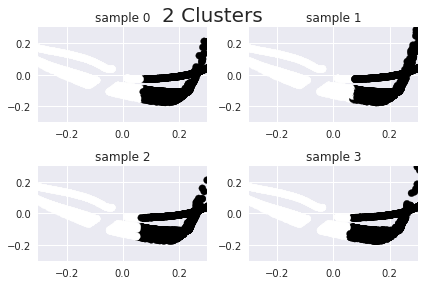

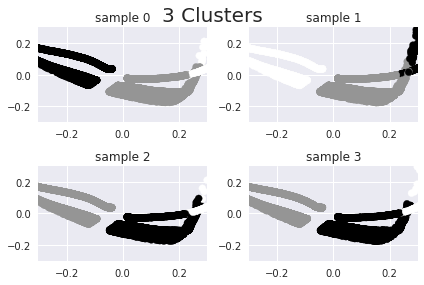

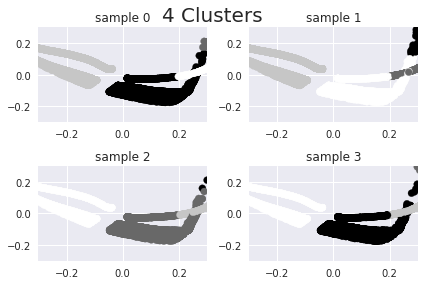

In [109]:
#Pass tuples into a list to be used by K-means
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
        #Add features to ypred.
        ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
        ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            kmeans = KMeans(n_clusters = nclust, random_state=42)
            pred = kmeans.fit_predict(data[0]) #data[0] is X or sample
            ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = kmeans.labels_
            score = metrics.silhouette_score(data[0], labels, metric='euclidean')
            scores = scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'score': score}, ignore_index=True)
            
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')
            

In [110]:
scores.sort_values(by='score', ascending=False)

,cluster,score
11,clust4_sample3,0.494623
5,clust4_sample1,0.494448
8,clust4_sample2,0.493280
2,clust4_sample0,0.490502
7,clust3_sample2,0.480800
4,clust3_sample1,0.478718
10,clust3_sample3,0.478513
1,clust3_sample0,0.474704
0,clust2_sample0,0.464484
9,clust2_sample3,0.461082


4 samples has both the highest scores and the most consistent scores. We used sihouette instead of ARI becuase we don't have a "ground truth".

## Spectral Clustering

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


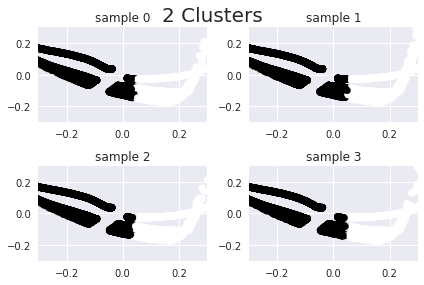

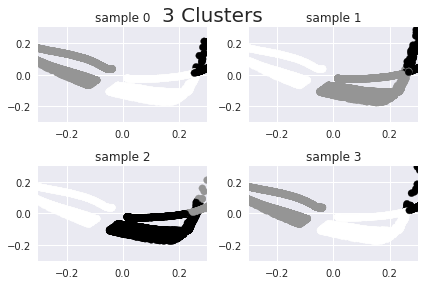

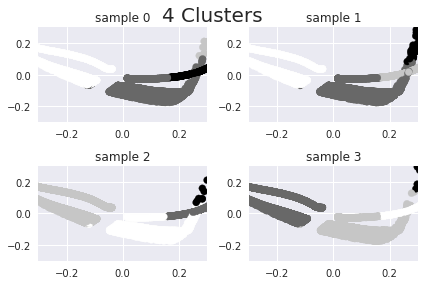

In [28]:
#re-initialize dfs
sc_scores = pd.DataFrame(columns = ['cluster', 'score']) #silhoute score
sc_ypred = pd.DataFrame()
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
        #Add features to sc_ypred.
        sc_ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
        sc_ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            sc = SpectralClustering(n_clusters = nclust, random_state=42)
            pred = sc.fit_predict(data[0]) #data[0] is X or sample
            sc_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = sc.labels_
            sc_score = metrics.silhouette_score(data[0], labels, metric='euclidean')
            sc_scores = sc_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'score': sc_score}, ignore_index=True)
            
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = sc_ypred['pca_f1_sample{}'.format(i)]
        y_sub = sc_ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = sc_ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')
            

In [29]:
sc_scores.sort_values(by='score', ascending=False)

,cluster,score
11,clust4_sample3,0.491312
5,clust4_sample1,0.490632
8,clust4_sample2,0.489900
2,clust4_sample0,0.485686
7,clust3_sample2,0.480765
4,clust3_sample1,0.478232
10,clust3_sample3,0.477068
1,clust3_sample0,0.472798
9,clust2_sample3,0.448360
0,clust2_sample0,0.445663


Again 4 clusters has the best scores and the tighest range of scores. It performs slightly worse than K-means. 

## Mean-Shift Clustering

In [30]:
#re-initialize dfs
ms_scores = pd.DataFrame(columns = ['cluster', 'ms_score']) #silhoute score
ms_ypred = pd.DataFrame()

for counter, data in enumerate([X1, X2, X3, X4]):
   
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, n_samples=500)
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            pred = ms.fit_predict(data) #data[0] is X or sample
            ms_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = ms.labels_
            ms_score = metrics.silhouette_score(data, labels, metric='euclidean')
            ms_scores = ms_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'ms_score': ms_score}, ignore_index=True)
            
            

In [31]:
ms_scores.sort_values(by='ms_score', ascending=False)

,cluster,ms_score
3,clust2_sample1,0.559720
4,clust3_sample1,0.559720
5,clust4_sample1,0.559720
0,clust2_sample0,0.496654
1,clust3_sample0,0.496654
2,clust4_sample0,0.496654
9,clust2_sample3,0.494659
10,clust3_sample3,0.494659
11,clust4_sample3,0.494659
6,clust2_sample2,0.494610


I wish I could have gotten the graphing to work, because the scores are very similar. Mean-Shift didn't perform very well across the different samples, but the lower performing scores were higher than what we saw from K-means and Spectral Clustering. Becuase all of the ranges vary, 2 clusters performed best here. 

## Affinity Propogation

In [ ]:
#re-initialize dfs
ap_scores = pd.DataFrame(columns = ['cluster', 'ap_score']) #silhoute score
ap_ypred = pd.DataFrame()

for counter, data in enumerate([X1, X2, X3, X4]):
   
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, n_samples=500)
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            af = AffinityPropagation().fit(data)
            cluster_centers_indices = af.cluster_centers_indices_
            n_clusters_ = len(cluster_centers_indices)
            
            #ms_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            #Create scores
            labels = af.labels_
            af_score = metrics.silhouette_score(data, labels, metric='euclidean')
            af_scores = af_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'af_score': af_score}, ignore_index=True)

I can't get Affinity Propogation to finish running, even on Google Cloud with (8 vCPUs, 30 GB memory). Based on my expertise in this area that I acquired in the past two lessons, Affinity Propogation would have performed horribly. 

## Model Summary

K-Means and Spectral Clustering performed reasonably well and the silhouette scores were consistent across the samples, both suggest 4 clusters were the correct amount. Mean-Shift clustering had higher silhoutte scores, but it didn't hold up well within samples - it suggested 2 clusters. 

Now, let's try to map these predictions back onto our original data set. We'll use the k-means model to predict our labels. 

In [111]:
predict=kmeans.predict(bm)

In [112]:
bm['predict'] = predict

In [113]:
bm.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,predict
9,30.48,20,77.68,0,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83,2
14,17.12,13,48.88,0,29,87.40,13,72.83,13,3.35,60.82,8.02,40.20,38.02,82.38,2
15,33.93,10,85.03,1,30,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47,2
24,18.30,14,50.33,0,47,89.40,14,74.95,14,3.42,62.33,8.67,41.80,39.63,84.48,2
27,18.78,15,50.33,0,30,89.52,15,75.02,15,3.42,62.72,8.98,41.82,39.65,84.75,2


In [114]:
bm.predict.value_counts()

0    13503
3    12511
1     2810
2      279
Name: predict, dtype: int64

In [115]:
bm.predict.groupby(bm['gender']).value_counts()

gender  predict
0       3          12511
        1           2810
        2            257
1       0          13503
        2             22
Name: predict, dtype: int64

In [116]:
bm['age'].groupby(bm['predict']).describe().transpose()

predict,0,1,2,3
count,13503.000000,2810.000000,279.00000,12511.000000
mean,39.575280,31.588612,31.74552,47.310287
std,10.487493,5.026892,7.18585,10.621899
min,18.000000,18.000000,18.00000,18.000000
25%,31.000000,28.000000,27.00000,41.000000
50%,40.000000,32.000000,30.00000,47.000000
75%,47.000000,36.000000,35.00000,55.000000
max,81.000000,39.000000,59.00000,81.000000


In [117]:
bm['pace'].groupby(bm['predict']).describe().transpose()

predict,0,1,2,3
count,13503.000000,2810.000000,279.000000,12511.000000
mean,9.696633,6.977214,5.639140,9.403858
std,1.770071,0.472795,0.634124,1.909159
min,6.200000,6.050000,3.250000,6.120000
25%,8.370000,6.630000,5.610000,7.970000
50%,9.230000,6.930000,5.850000,8.950000
75%,10.730000,7.330000,5.970000,10.620000
max,17.620000,7.970000,7.300000,20.570000


It worked! And it looks like it split the runners into the very top finishers (group 2), then a group of sligthly slower men(group 1), then it split the runners into men and women(3,0), that's why we see such a large variance in the groups. 

In [118]:
bins = [18,30,40,50,60,85]
labels=['18-30','30-40','40-50','50-60', '60+']
bm['age_category'] = pd.cut(bm['age'], bins=bins, labels=labels, include_lowest=True)

In [119]:
bm0 = bm[bm.predict == 0]
bm1 = bm[bm.predict == 1]
bm2 = bm[bm.predict == 2]
bm3 = bm[bm.predict == 3]

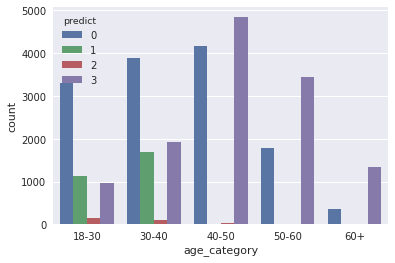

In [134]:
import warnings
warnings.filterwarnings('ignore')

sns.countplot(x="age_category", hue = 'predict', data=bm)
plt.show()

Splitting the field into age categories, we can see the top two finishing clusters have a mix of ages from 18-50, with 18-30 in the top group. Why don't these skew even more towards the younger runners? Because the main predictor of marathon times is miles run. Runners under the age of 20-22 typically haven't accumulated the mileage necessary to be a top competitor. That's why we can see plenty of runners over the age of 30 represented in groups 1 and 2. If this were track and field events we probably wouldn't see anyone over 35. 

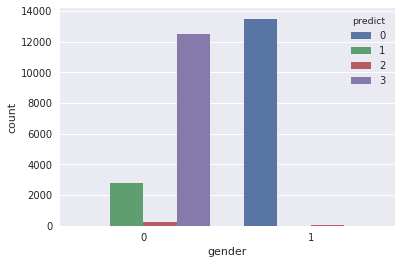

In [135]:
sns.countplot(x="gender", hue = 'predict', data=bm)

Most of the women got lumped into one cluster, although there are a few in the top finishing groups. 

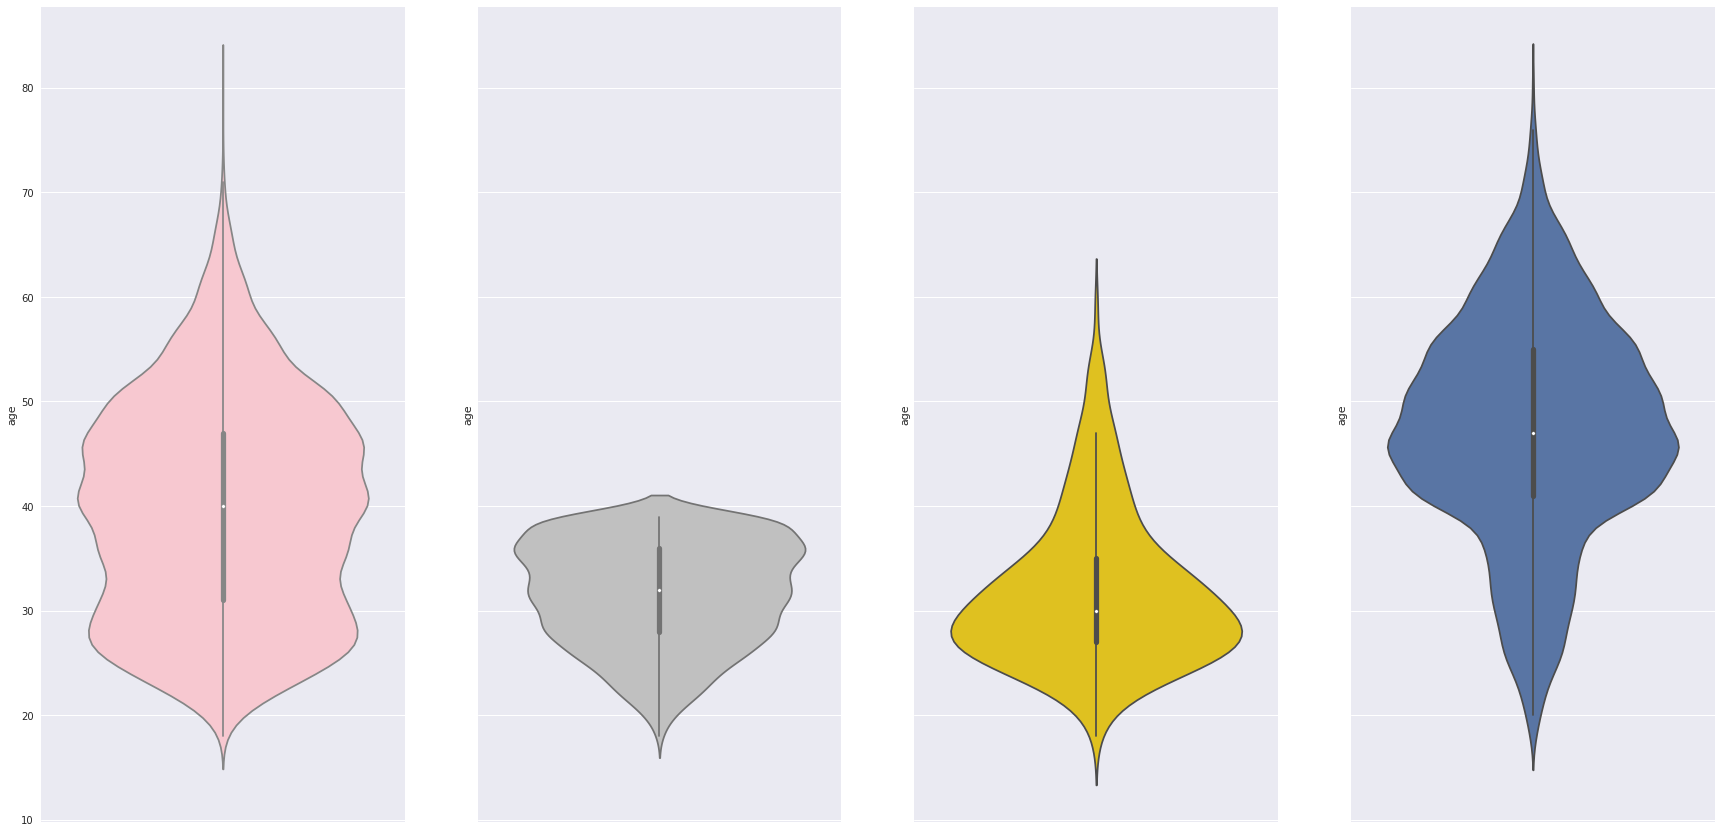

In [147]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows= 1, sharey=True, figsize=(30,15))
sns.violinplot(y= 'age',  data = bm0 ,ax = ax1, color = 'pink')
sns.violinplot(y= 'age',  data = bm1, ax = ax2, color = '#C0C0C0')
sns.violinplot(y= 'age', data = bm2, ax = ax3, color = 'gold' )
sns.violinplot(y= 'age',  data = bm3, ax = ax4 )
plt.show()

We can again see that while the marathons skew younger, although I'm fairly certain those outliers in the gold group are people in wheelchairs which typically finish the race much sooner. We know from the statistics above that the max pace for the gold group was 7:30, although maybe there are some superhereos running 7:30 min/mile marathons over 60. 

We can also see that women running marathons tend to be much younger. This could have something to do with women losing bone density at a younger age compared to men. Anecdotally, 3 of my female friends are married to men 8-10 years older than them, all 3 of them are marathon runners and married other runners they met at races. Coincidence? 

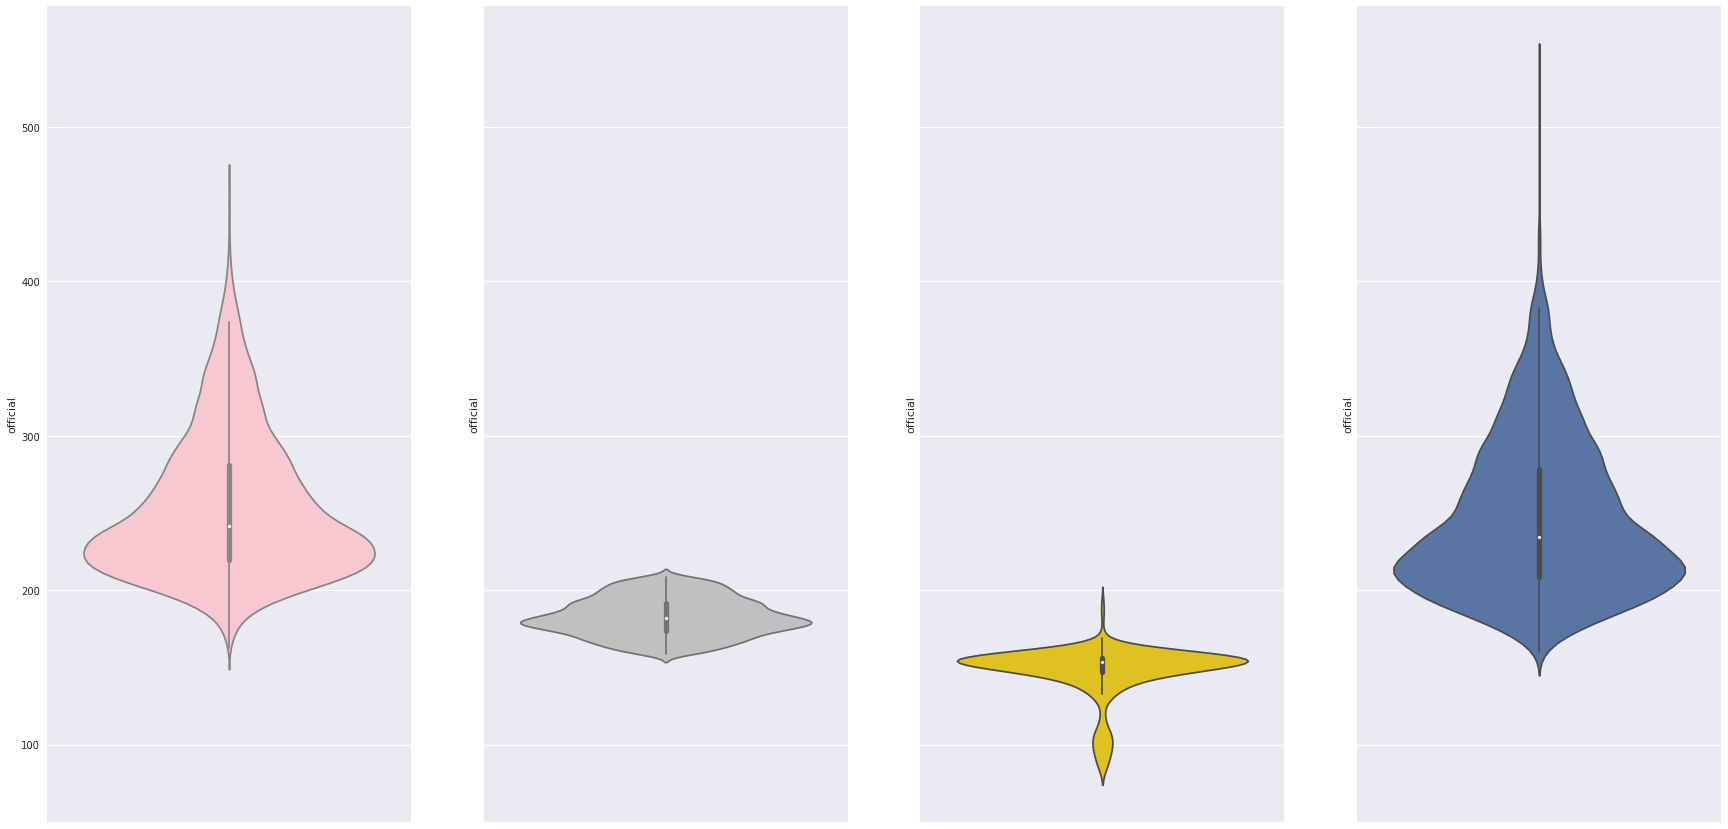

In [145]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows= 1, sharey=True, figsize=(30,15))
sns.violinplot(y= 'official',  data = bm0 ,ax = ax1 , color = 'pink')
sns.violinplot(y= 'official',  data = bm1, ax = ax2, color = '#C0C0C0') # silver
sns.violinplot(y= 'official', data = bm2, ax = ax3, color = 'gold')
sns.violinplot(y= 'official',  data = bm3, ax = ax4 )

plt.show()


The elite group of rollers/runners finish before almost anyone in the other groups finish, although I am curious about those outliers at the top. 

Women's finishing times are just behind the mean finishing time of the men's cluster, but they also don't have as many outliers. This seems to be almost entirely due to men running marathons into their 80s where most female runners seem to stop either running in or qualifying for the boston marathon as they approach 60. 

In [151]:
bm1.sort_values(by = 'official', ascending = False)

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,predict,age_category
1601,44.53,3288,112.00,0,32,208.67,6976,166.88,8888,7.97,137.12,22.45,93.98,89.08,197.43,1,30-40
1981,41.72,3289,104.15,0,26,208.67,6977,169.75,8890,7.97,128.17,20.97,87.70,83.13,197.05,1,18-30
4818,46.02,3287,116.43,0,26,208.63,6972,169.58,8880,7.97,142.42,22.60,97.85,92.80,196.78,1,18-30
4783,44.82,3286,113.45,0,21,208.57,6959,163.75,8856,7.97,138.10,22.50,95.43,90.42,195.05,1,18-30
2850,41.15,3285,105.28,0,38,208.57,6958,159.38,8855,7.97,128.27,20.70,87.92,83.32,192.18,1,30-40
24382,42.67,3284,111.75,0,36,208.47,6947,165.87,8828,7.97,138.03,20.58,92.95,88.03,195.92,1,30-40
5549,42.95,3283,111.45,0,38,208.45,6943,167.00,8820,7.95,137.62,21.48,92.75,87.78,196.28,1,30-40
5774,46.57,3281,117.43,0,36,208.40,6930,170.67,8799,7.95,143.85,23.42,98.30,93.27,196.83,1,30-40
5100,46.22,3282,119.22,0,35,208.40,6932,169.85,8802,7.95,144.18,23.00,100.23,94.73,196.13,1,30-40
6246,42.50,3280,106.92,0,37,208.38,6929,163.05,8796,7.95,131.25,21.38,89.57,84.83,192.55,1,30-40


It seems as though the classifier just missed on some of these outliers. Nothing jumps out as to why the late 20s & 30's men would have been grouped in the elite runners group. They are consistenly way off the pace at every split compared to the rollers/runners that finished in the first group. 

### Conclusion

We saw the interesting bins the classifiers put runners into. I was expecting the runners to be placed into finishing groups, but instead it used gender as the component to split the two largest clusters. It was somewhat challenging to perform analysis on the data after it was clustered just becuase I had to work with the gender split for two groups when I might not have gone that direction for a few of my visualizations.

To extend this, I'd like to go back and re-run the classifiers without the gender column, then use gender as a hue if I wanted to compare difference in genders by cluster. 

